# Let's measure some rotation periods of CVZ stars!

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load the TESS-Hermes catalog.

In [27]:
df09 = pd.read_csv("../G011291_S009.csv")
df10 = pd.read_csv("../G011291_S010.csv")
df11 = pd.read_csv("../G011291_S011.csv")
df12 = pd.read_csv("../G011291_S012.csv")
df13 = pd.read_csv("../G011291_S013.csv")
df = pd.concat((df09, df10, df11, df12, df13))
np.shape(df)

(571, 5)

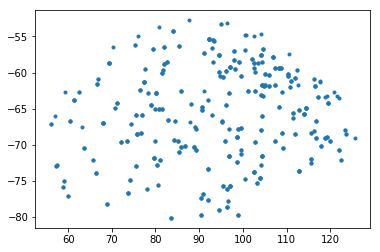

In [29]:
plt.plot(df.RA, df.Dec, ".")

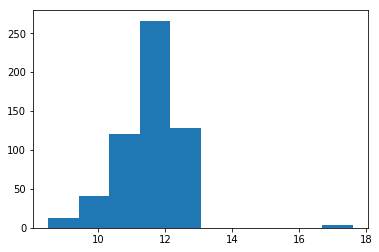

In [31]:
plt.hist(df.Tmag);

In [33]:
import lightkurve as lk

starname = "TIC {}".format(df.TICID.values[0])
lcf = lk.search_lightcurvefile(starname).download()

TimeoutError: Timeout limit of 600 exceeded.

In [ ]:
lc = lcf.PDCSAP_FLUX
lc.scatter(alpha=.5, s=.5);